<a href="https://colab.research.google.com/github/talmolab/sleap/blob/main/docs/notebooks/Interactive_and_realtime_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive and realtime inference

For most workflows, using the [`sleap-track` CLI](https://sleap.ai/guides/cli.html#sleap-track) is probably the most convenient option, but if you're developing a custom application you can take advantage of SLEAP's inference API to use your trained models in your own custom scripts.

In this notebook we will explore how to predict poses from raw images in pure Python, and do some basic benchmarking on a simulated realtime predictor that could be used to enable closed-loop experiments.

## 1. Setup SLEAP

Run this cell first to install SLEAP. If you get a dependency error in subsequent cells, just click **Runtime** → **Restart runtime** to reload the packages.

Don't forget to set **Runtime** → **Change runtime type** → **GPU** as the accelerator.

In [1]:
# This should take care of all the dependencies on colab:
!pip uninstall -qqq -y opencv-python opencv-contrib-python
!pip install -qqq "sleap[pypi]>=1.3.3"


# But to do it locally, we'd recommend the conda package (available on Windows + Linux):
# conda create -n sleap -c sleap -c conda-forge -c nvidia sleap

ERROR: Cannot uninstall opencv-python 4.6.0, RECORD file not found. Hint: The package was installed by conda.
ERROR: Cannot uninstall shiboken2 5.15.6, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps shiboken2==5.15.6'.


Import SLEAP to make sure it installed correctly and print out some information about the system:

In [2]:
import sleap
sleap.disable_preallocation()  # This initializes the GPU and prevents TensorFlow from filling the entire GPU memory
sleap.versions()
sleap.system_summary()

SLEAP: 1.3.2
TensorFlow: 2.7.0
Numpy: 1.21.5
Python: 3.7.12
OS: Linux-5.15.0-78-generic-x86_64-with-debian-bookworm-sid
GPUs: 1/1 available
  Device: /physical_device:GPU:0
         Available: True
        Initalized: False
     Memory growth: True


2023-09-01 13:56:37.731425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-01 13:56:37.735933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-01 13:56:37.736867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## 2. Setup data

Before we start, let's download a raw video and a set of trained top-down ID models that we'll use to build our application around.

In [3]:
!curl -L --output video.mp4 https://storage.googleapis.com/sleap-data/reference/flies13/190719_090330_wt_18159206_rig1.2%4015000-17560.mp4
!curl -L --output centroid_model.zip https://storage.googleapis.com/sleap-data/reference/flies13/centroid.fast.210504_182918.centroid.n%3D1800.zip
!curl -L --output centered_instance_id_model.zip https://storage.googleapis.com/sleap-data/reference/flies13/td_id.fast.v2.210519_111253.multi_class_topdown.n%3D1800.zip
!ls -lah

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 81.3M  100 81.3M    0     0  23.7M      0  0:00:03  0:00:03 --:--:-- 23.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6223k  100 6223k    0     0  30.2M      0 --:--:-- --:--:-- --:--:-- 30.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32.2M  100 32.2M    0     0  14.5M      0  0:00:02  0:00:02 --:--:-- 14.5M
total 1.1G
drwxrwxr-x  5 talmolab talmolab 4.0K Sep  1 13:56  .
drwxrwxr-x 10 talmolab talmolab 4.0K Aug 31 15:43  ..
-rw-rw-r--  1 talmolab talmolab  82M May 20  2021  190719_090330_wt_18159206_rig1.2@15000-17560.mp4.1
-rw-rw-r--  1 talmolab talmolab 1.6M May 20  2021  190719_090330_wt_1

**Note:** These zip files just have the contents of standard SLEAP model folders that are generated during training.

## 3. Interactive inference

SLEAP provides a high-level API for performing inference in the form of `Predictor` classes specific to each approach/model type.

To create one from a set of trained models, we can use the high-level `sleap.load_model()` function:

In [4]:
predictor = sleap.load_model(["centroid_model.zip", "centered_instance_id_model.zip"], batch_size=16)

2023-09-01 13:57:04.806004: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 13:57:04.807011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-01 13:57:04.807970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-01 13:57:04.808962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

This function handles all the logic of loading trained models, reading the configurations used to train them, and constructs inference models that also include non-trainable operations like peak finding and instance grouping.

Next, we'll load a video that we want to use for inference. SLEAP `Video` objects don't actually load the whole video into memory, they just provide a common numpy-like interface for reading from different file formats:

In [5]:
video = sleap.load_video("video.mp4")
video.shape, video.dtype

((2560, 1024, 1024, 1), dtype('uint8'))

Our predictor is pretty flexible. It can handle a variety of different input formats, all of which will return a `Labels` object that contains all of our predictions:

In [6]:
# Load frames to a numpy array.
imgs = video[:100]
print(f"imgs.shape: {imgs.shape}")

# Predict on numpy array.
predictions = predictor.predict(imgs)
predictions

Output()

imgs.shape: (100, 1024, 1024, 1)


2023-09-01 13:57:13.455046: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


2023-09-01 13:57:15.358483: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Labels(labeled_frames=100, videos=1, skeletons=1, tracks=2)

We can then inspect the results of our predictor:

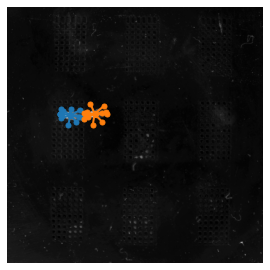

In [8]:
# Visualize a frame.
predictions[100].plot(scale=0.25)

In [9]:
# Inspect the contents of a single frame.
labeled_frame = predictions[100]
labeled_frame.instances

[PredictedInstance(video=Video(filename=video.mp4, shape=(2560, 1024, 1024, 1), backend=MediaVideo), frame_idx=100, points=[head: (212.5, 427.0, 0.94), thorax: (252.0, 433.1, 0.95), abdomen: (288.6, 439.3, 0.68), wingL: (304.5, 443.3, 0.88), wingR: (306.2, 435.8, 0.68), forelegL4: (216.2, 445.5, 0.88), forelegR4: (216.1, 410.0, 0.90), midlegL4: (244.4, 471.3, 0.90), midlegR4: (256.6, 408.9, 0.86), hindlegL4: (275.0, 459.2, 0.89), hindlegR4: (292.3, 412.0, 0.81), eyeL: (220.0, 438.0, 0.84), eyeR: (223.8, 417.5, 0.91)], score=0.99, track=Track(spawned_on=0, name='female'), tracking_score=0.00),
 PredictedInstance(video=Video(filename=video.mp4, shape=(2560, 1024, 1024, 1), backend=MediaVideo), frame_idx=100, points=[head: (313.7, 432.6, 0.87), thorax: (348.9, 427.9, 1.00), abdomen: (378.9, 425.8, 0.83), wingL: (397.0, 428.7, 0.89), wingR: (394.9, 420.7, 0.74), forelegL4: (307.4, 446.4, 0.88), forelegR4: (306.5, 422.5, 0.89), midlegL4: (341.6, 474.2, 0.97), midlegR4: (332.6, 386.3, 0.97),

In [10]:
# Convert an instance to a numpy array:
labeled_frame[0].numpy()

rec.array([[212.51400757, 426.97024536],
           [251.97747803, 433.08648682],
           [288.64355469, 439.3086853 ],
           [304.53396606, 443.33477783],
           [306.20336914, 435.77227783],
           [216.24688721, 445.47549438],
           [216.14550781, 409.98342896],
           [244.39497375, 471.31561279],
           [256.61740112, 408.89056396],
           [274.97470093, 459.1831665 ],
           [292.2600708 , 411.95904541],
           [219.98565674, 437.97906494],
           [223.75566101, 417.5496521 ]],
          dtype=float64)

What if we don't want or need the inference results wrapped in the SLEAP structures?

By using the low-level inference model, we can actually go directly from image to numpy arrays of our results:

In [11]:
imgs = video[:16]  # batch of 16 images

predictions = predictor.inference_model.predict(imgs, numpy=True)
predictions

4/4 [==============================] - 2s 176ms/step


{'instance_peaks': array([[[[234.2224 , 430.62598],
          [271.5043 , 436.13202],
          [309.87125, 436.64966],
          [324.12512, 438.3908 ],
          [320.3458 , 435.9504 ],
          [246.42352, 450.67786],
          [242.37636, 413.81458],
          [285.5624 , 460.22766],
          [273.45117, 406.51895],
          [      nan,       nan],
          [      nan,       nan],
          [241.9716 , 442.32303],
          [245.46788, 421.90228]],
 
         [[319.80017, 435.48407],
          [351.93695, 434.0301 ],
          [369.43228, 431.78564],
          [393.89014, 481.0584 ],
          [398.4241 , 429.79565],
          [      nan,       nan],
          [305.42896, 419.3896 ],
          [325.67926, 475.0098 ],
          [331.97974, 384.30814],
          [363.66406, 473.9354 ],
          [377.3852 , 398.13065],
          [328.40244, 445.51434],
          [328.1667 , 423.94733]]],
 
 
        [[[234.36913, 430.38037],
          [271.65576, 436.0479 ],
          [311.6751 ,

In [12]:
for key, value in predictions.items():
    print(f"'{key}': {value.shape} ({value.dtype})")

'instance_peaks': (16, 2, 13, 2) (float32)
'instance_peak_vals': (16, 2, 13) (float32)
'instance_scores': (16, 2) (float32)
'centroids': (16, 2, 2) (float32)
'centroid_vals': (16, 2) (float32)
'n_valid': (16,) (int32)


## 4. Realtime performance

Now that we know how to do inference with different types of outputs, let's try to use that to build a simulated "realtime" application with timing.

First, we'll create a class that simulates a camera grabber API that provides a sequence of pre-loaded frames.

In [13]:
from time import perf_counter
import numpy as np


class SimulatedCamera:
    """Simulated camera class that serves frames from memory continuously.

    Attributes:
        frames: Numpy array with pre-loaded frames.
        frame_counter: Count of frames that have been grabbed.
    """

    frames: np.ndarray
    frame_counter: int

    def __init__(self, frames):
        self.frames = frames
        self.frame_counter = 0
    
    def grab_frame(self):
        idx = self.frame_counter % len(self.frames)
        self.frame_counter += 1
        return self.frames[idx]


Then, we'll define a simply acquisition loop, in which we repeatedly grab a frame and perform inference to time how long it takes.

In [14]:
recording_duration = 100  # session length in frames

# Pre-load images onto "camera"
camera = SimulatedCamera(video[:512])

# Camera capture loop
inference_times = []
frames_recorded = 0
while frames_recorded < recording_duration:
    # Get the next frame.
    frame = camera.grab_frame()
    frames_recorded += 1

    # Get inference results for the frame and time how long it took.
    t0 = perf_counter()
    frame_predictions = predictor.inference_model.predict_on_batch(np.expand_dims(frame, axis=0))
    dt = perf_counter() - t0
    inference_times.append(dt)

# Convert to milliseconds.
inference_times = np.array(inference_times) * 1000

# Separate out first timing from the rest. The first inference call is much slower as it builds the compute graph.
first_inference_time, inference_times = inference_times[0], inference_times[1:]
print(f"First inference time: {first_inference_time:.1f} ms")
print(f"Inference times: {inference_times.mean():.1f} +- {inference_times.std():.1f} ms")

First inference time: 886.2 ms
Inference times: 63.1 +- 1.2 ms


After the first batch, our inference latencies go way down and we can see how they vary over time:

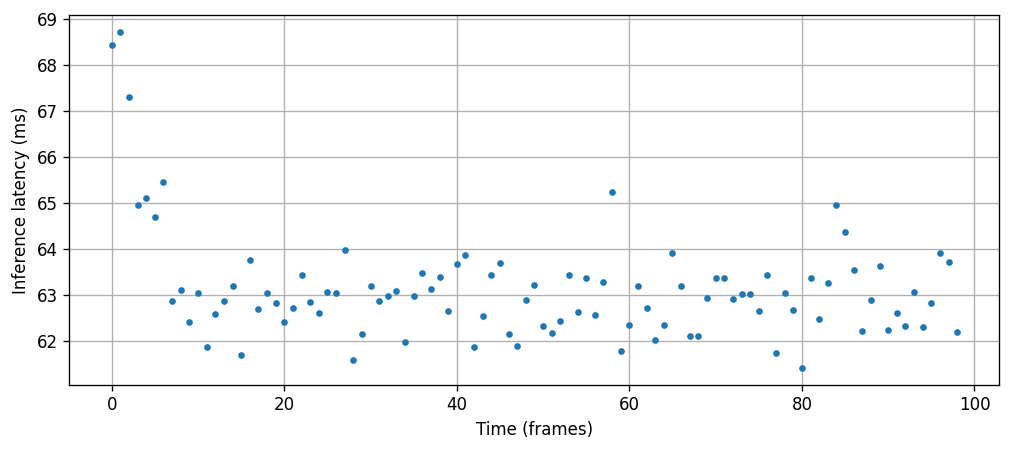

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4), dpi=120, facecolor="w")
plt.plot(inference_times, ".")
plt.xlabel("Time (frames)")
plt.ylabel("Inference latency (ms)")
plt.grid(True);

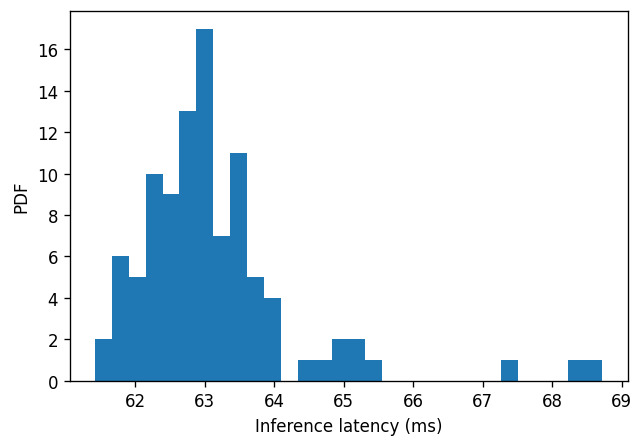

In [16]:
plt.figure(figsize=(6, 4), dpi=120, facecolor="w")
plt.hist(inference_times, bins=30)
plt.xlabel("Inference latency (ms)")
plt.ylabel("PDF");